In [182]:
from manifold_learning import IMD, CCM
import numpy as np
from pydmd import DMD, BOPDMD
from manifold_learning.utils import utils
from sklearn.decomposition import PCA
from pydmd.preprocessing import zero_mean_preprocessing
from pydmd.plotter import plot_summary
from manifold_learning.data.data_loader import load_csv_dataset,get_truncated_lorenz_rand
import matplotlib.pyplot as plt
import imageio
import os
import tempfile


In [4]:
X = get_truncated_lorenz_rand(400,n_steps=20000)

In [2]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

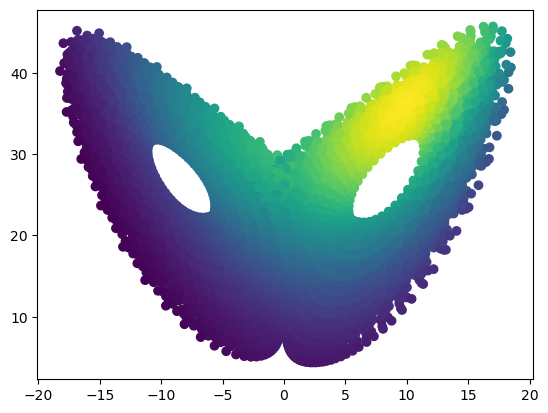

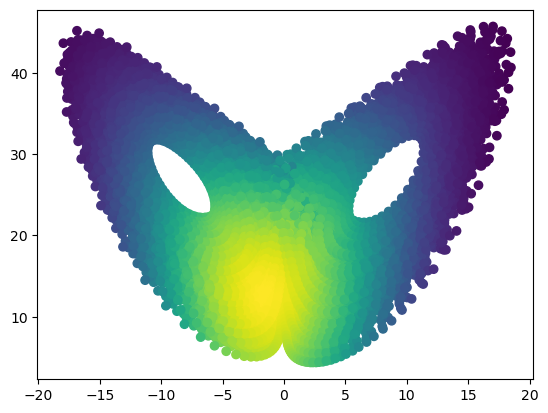

In [6]:
plt.scatter(X[:,0],X[:,2],c=gaussian_kernel(X,X[1100],sigma=15))
plt.show()
plt.scatter(X[:,0],X[:,2],c=gaussian_kernel(X,X[1800],sigma=15))
plt.show()

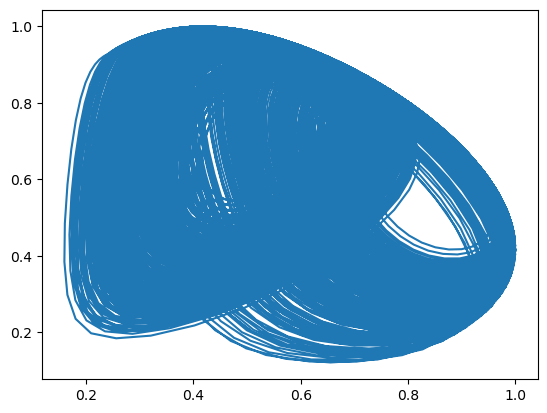

In [5]:
plt.plot(gaussian_kernel(X,X[1100],sigma=20),gaussian_kernel(X,X[1800],sigma=20))

In [153]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),6), np.linspace(X[:,2].min(),X[:,2].max(),6))).reshape(2,-1).T

In [6]:
observables = np.array([gaussian_kernel(X[:,[0,2]],e,sigma=5) for e in exp_kernel_grid]).T

In [374]:

with tempfile.TemporaryDirectory() as tempdir:
    filenames = []
    for i, frame in enumerate(observables.reshape(-1,40,40)[:2000]):
        plt.imshow(frame, cmap='viridis')
        plt.axis('off')
        filename = os.path.join(tempdir, f'frame_{i}.png')
        plt.savefig(filename)
        filenames.append(filename)
        plt.close()

    with imageio.get_writer('output.mp4', fps=30) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

/tmp/ipykernel_141465/4228224139.py:13: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [162]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=15) for e in exp_kernel_grid]) for x in X_]).T


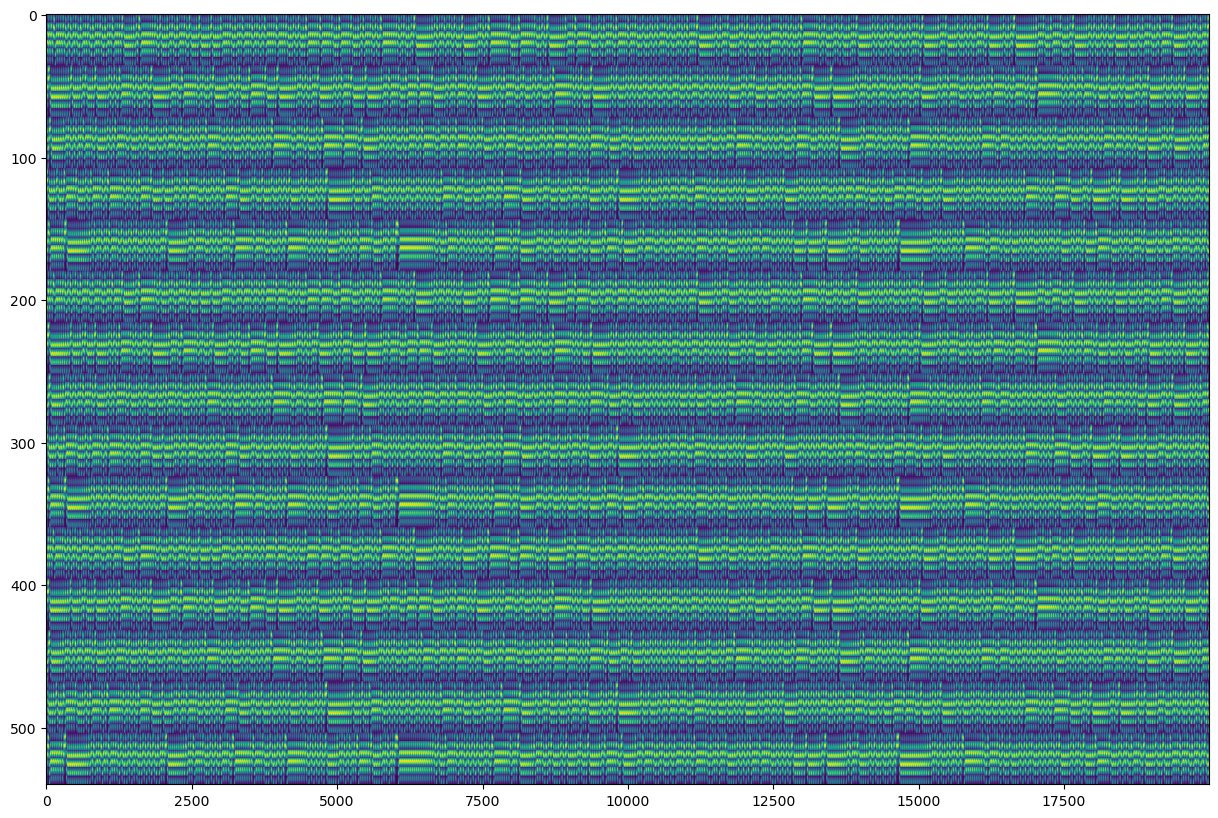

In [196]:
plt.figure(figsize=(15,10))
plt.imshow(observables.T,aspect="auto")

In [195]:
observables = utils.get_td_embedding_np(observables,3,5).reshape(-1,3*180)


In [199]:
trainer = IMD.IMD_nD(observables.shape[1], embed_dim=5, n_components=5,subtract_corr=True, device="cuda")

In [204]:
trainer.fit(observables, sample_len=400, library_len=1200, 
            exclusion_rad=20, nbrs_num=30, tp=15, 
            epochs=300, num_batches=32,optimizer="Adagrad", learning_rate=0.0004,tp_policy="fixed")


Epoch 1/300, Loss: 0.4766
Epoch 2/300, Loss: 0.4754
Epoch 3/300, Loss: 0.4741
Epoch 4/300, Loss: 0.4739
Epoch 5/300, Loss: 0.4732
Epoch 6/300, Loss: 0.4740
Epoch 7/300, Loss: 0.4708
Epoch 8/300, Loss: 0.4729
Epoch 9/300, Loss: 0.4738
Epoch 10/300, Loss: 0.4720
Epoch 11/300, Loss: 0.4713
Epoch 12/300, Loss: 0.4717
Epoch 13/300, Loss: 0.4682
Epoch 14/300, Loss: 0.4712
Epoch 15/300, Loss: 0.4694
Epoch 16/300, Loss: 0.4689
Epoch 17/300, Loss: 0.4736
Epoch 18/300, Loss: 0.4675
Epoch 19/300, Loss: 0.4662
Epoch 20/300, Loss: 0.4651
Epoch 21/300, Loss: 0.4670
Epoch 22/300, Loss: 0.4662
Epoch 23/300, Loss: 0.4659
Epoch 24/300, Loss: 0.4647
Epoch 25/300, Loss: 0.4650
Epoch 26/300, Loss: 0.4623
Epoch 27/300, Loss: 0.4617
Epoch 28/300, Loss: 0.4601
Epoch 29/300, Loss: 0.4617
Epoch 30/300, Loss: 0.4627
Epoch 31/300, Loss: 0.4623
Epoch 32/300, Loss: 0.4597
Epoch 33/300, Loss: 0.4630
Epoch 34/300, Loss: 0.4615
Epoch 35/300, Loss: 0.4622
Epoch 36/300, Loss: 0.4627
Epoch 37/300, Loss: 0.4588
Epoch 38/3

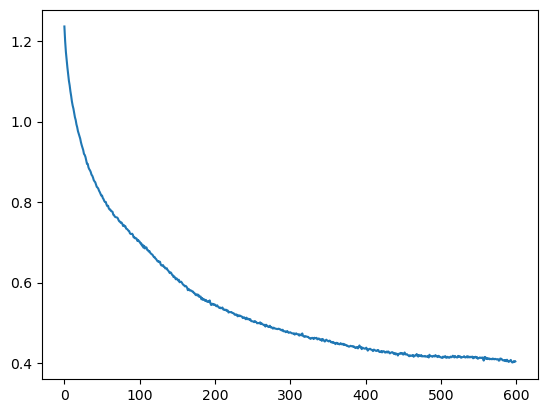

In [205]:
plt.plot(trainer.get_loss_history()[:])


In [206]:

unmixed = trainer.predict(observables)

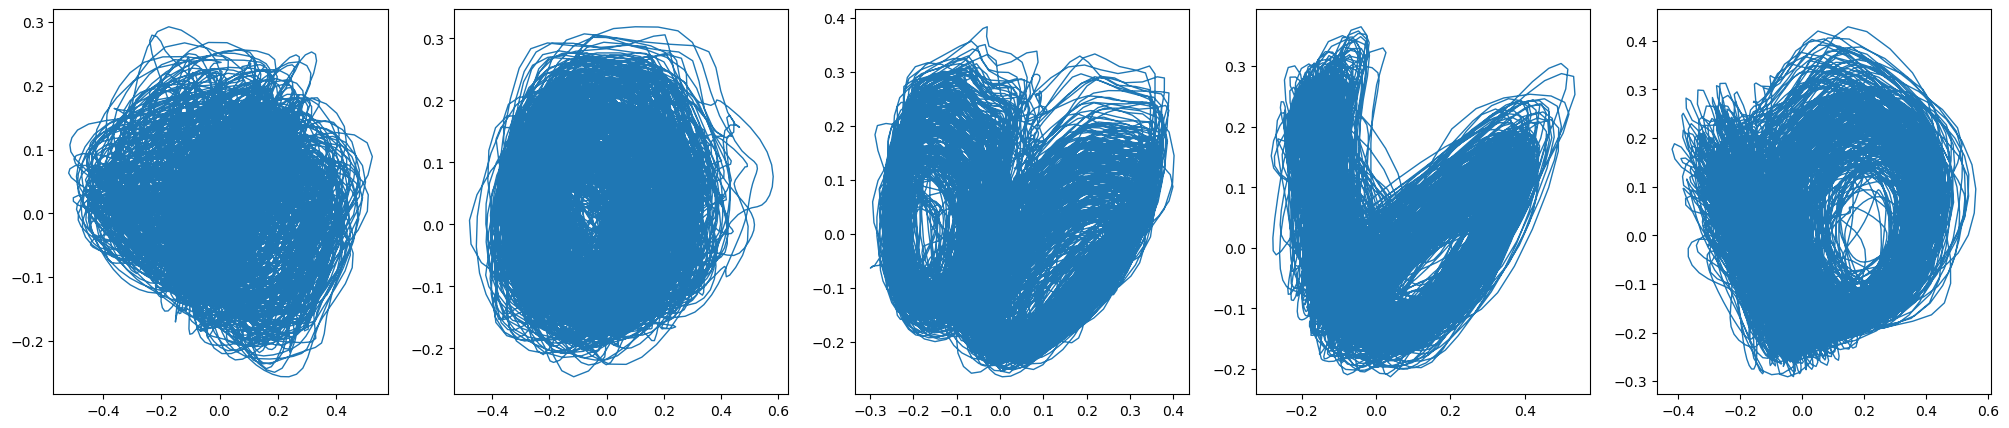

In [207]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

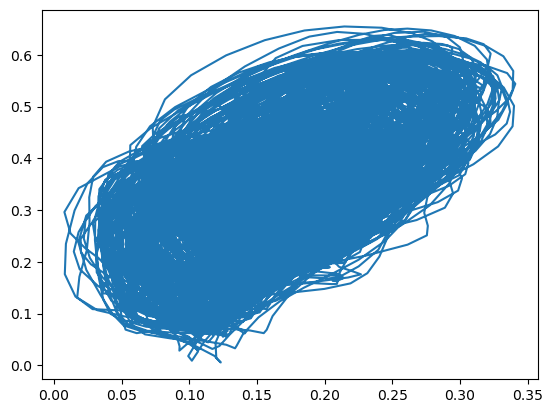

In [208]:
plt.plot(unmixed[:,0,0],unmixed[:,0,1])

In [209]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,3,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()

In [62]:
plt.matshow(trainer.model.get_weights()[:,0,0].reshape(10,20))

ValueError: cannot reshape array of size 500 into shape (10,20)

In [192]:
bopdmd = BOPDMD(svd_rank=3, num_trials=10)

bopdmd.fit(observables.T,np.arange(observables.shape[0]))

100 many trials without convergence. Consider loosening the tol requirements of the variable projection routine.


KeyboardInterrupt: 

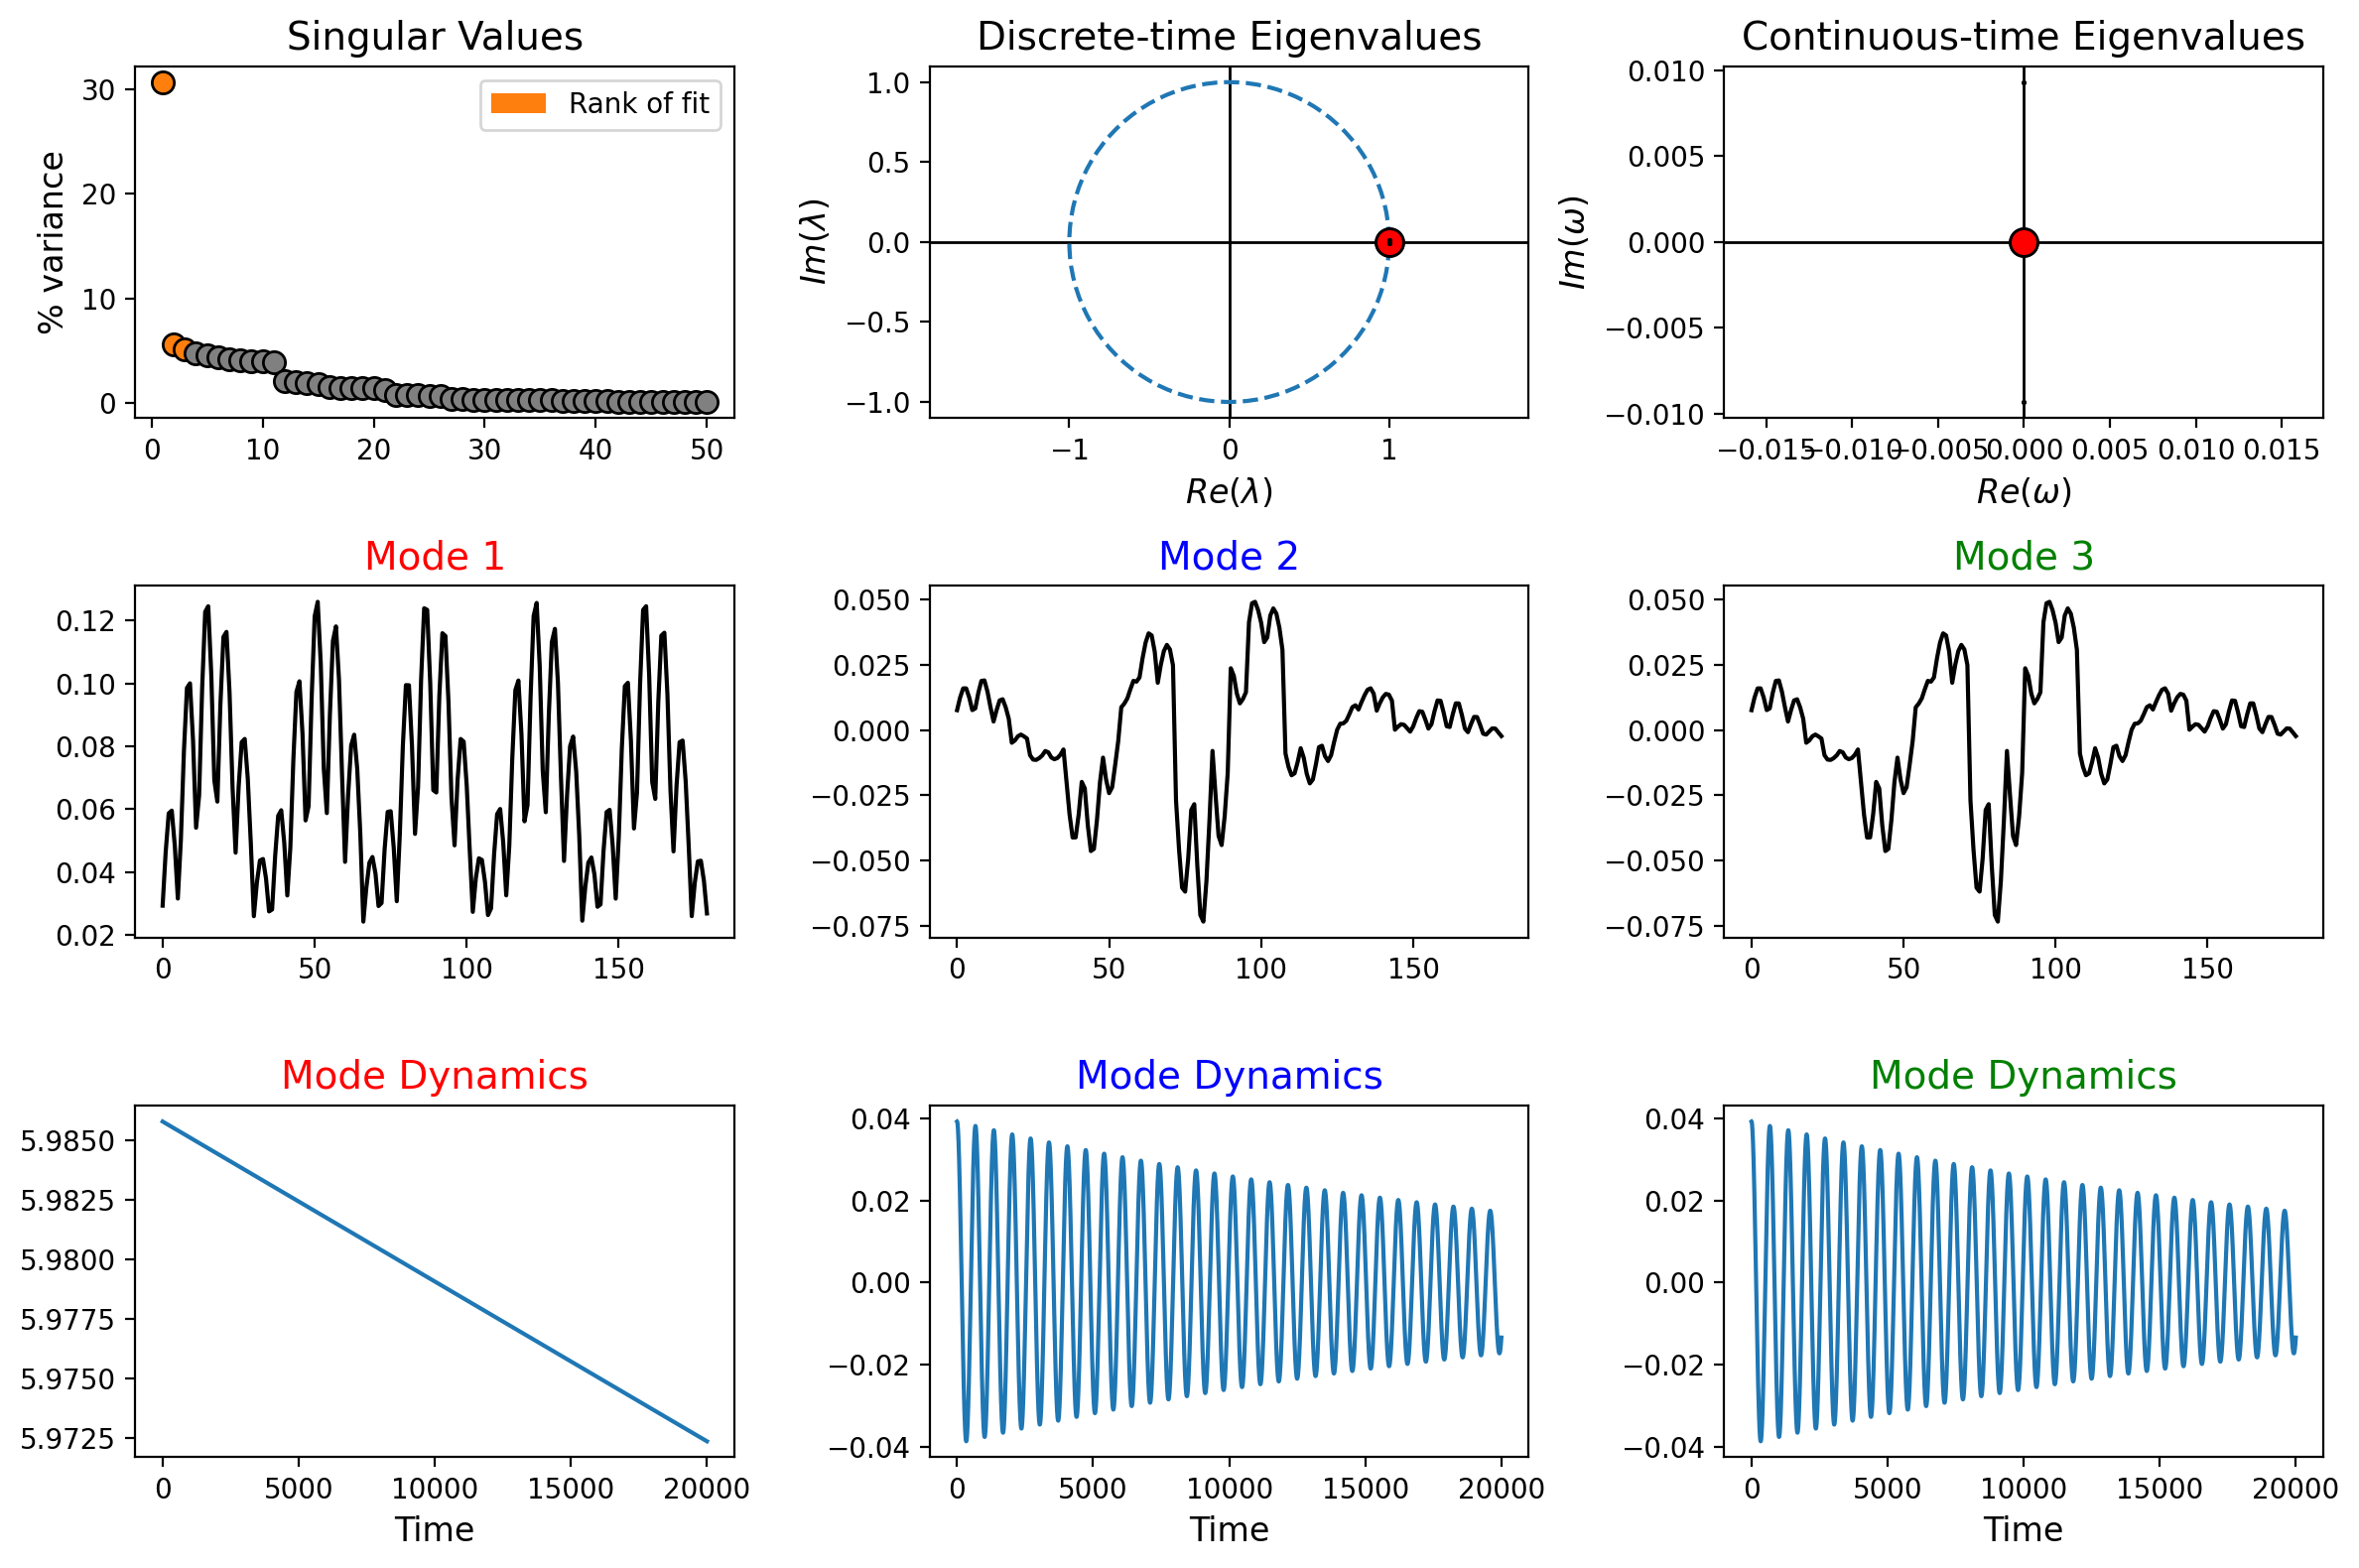

In [191]:

plot_summary(bopdmd)

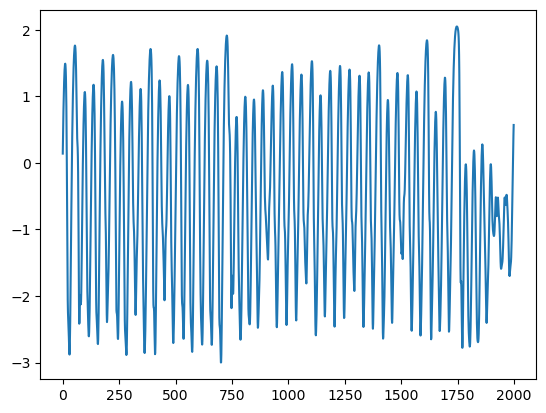

In [33]:
plt.plot((observables @ bopdmd.modes[:,2].real)[:2000])

/home/iaroslav/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/iaroslav/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



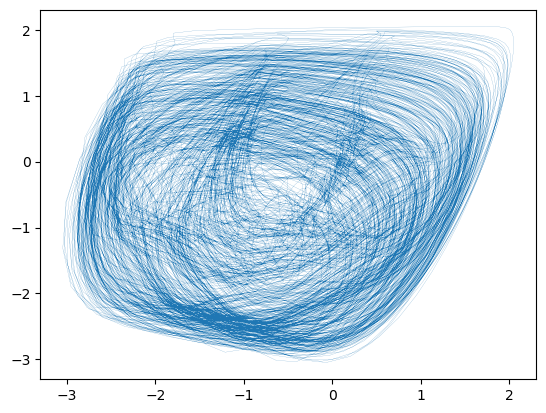

In [34]:
plt.plot((observables @ bopdmd.modes)[10:,1],(observables @ bopdmd.modes)[:-10,1],linewidth=0.1)